# Polygenic Risk Scores Combinations
The Polygenic Risk Score Combinations Project Version 1.0

Follow this Jupyter Notebook step-by-step to replicate our results.

### 1. Setup config.py File
1. Set parent directories
2. Name file names of your input files
    - Input files should be PRSKB output, adnimerge and dxsum
3. Define columns of interest for your DataFrames
    - All TSV columns listed are mandatory
    - ADNI columns 'RID' and 'PTID' are mandatory
    - All DX columns are mandatory

### 2. Import Packages

In [38]:
from config import tsv_path, tsv_cols, adni_path, adni_cols, dx_path, dx_cols
import pandas as pd
import numpy as np
from scipy.stats import gmean, hmean, ranksums, chisquare
import matplotlib.pyplot as plt

### 3. Initialize DataFrames and Global Variables

In [39]:
tsv_df = pd.read_csv(tsv_path, header=0, usecols=tsv_cols,sep='\t')
adni_df = pd.read_csv(adni_path, header=0,usecols=adni_cols)
dx_df = pd.read_csv(dx_path,header=0,usecols=dx_cols)
demographics = ['PTID','AGE','PTGENDER','PTRACCAT','APOE4','DIAGNOSIS','EXAMDATE']

### 4. Create Filtered Dataframe for Reported Trait
- tsv_df will be the input dataframe
- traits arg example: 'Alzheimer|Dementia'
- Separate multiple traits by a pipe operator
- Example usage filtered_df = filter_df(tsv_df,'Liver|Hepatic|Blood')

In [40]:
def filter_df(df,traits):
    df = df[df['Reported Trait'].str.contains(f'{traits}', case=False)].reset_index(drop=True)
    return df
filtered_df = filter_df(tsv_df,'Alzheimer|Dementia')
display(filtered_df.head(20))

,Sample,Study ID,Reported Trait,Percentile
0,003_S_1057,GCST007600,Alzheimer's Disease,96-99
1,003_S_0908,GCST007600,Alzheimer's Disease,13-14
2,003_S_1122,GCST007600,Alzheimer's Disease,37-39
3,136_S_0695,GCST007600,Alzheimer's Disease,81-90
4,136_S_0873,GCST007600,Alzheimer's Disease,81-90
5,130_S_0886,GCST007600,Alzheimer's Disease,6-9
6,012_S_1133,GCST007600,Alzheimer's Disease,71-72
7,003_S_1074,GCST007600,Alzheimer's Disease,96-99
8,037_S_0501,GCST007600,Alzheimer's Disease,37-39
9,027_S_0074,GCST007600,Alzheimer's Disease,43-58


### 5. Find the Earliest or Latest Diagnosis for a Patient in ADNI
- df is dx_df
- Options are 'Earliest' or 'Latest' EXAMDATE. For example, 'Earliest' would be 02/25/2006 andd 'Latest' would be 06/17/2011

In [41]:
def find_diagnosis(df,options):
    # Define options
    if options == 'Earliest':
        keep = 'first'
        fill = 'bfill'
    elif options == 'Latest':
        keep = 'last'
        fill = 'ffill'
    else: 
        raise ValueError("Enter 'Earliest' or 'Latest'")

    # Fill empty values depending on option selected
    df['EXAMDATE'] = df['EXAMDATE'].fillna(method=fill)
    df['DIAGNOSIS'] = df['DIAGNOSIS'].fillna(method=fill)

    # Keep only the earliest or latest diagnosis depending on the option selected
    df = df.drop_duplicates(subset='RID', keep=keep).reset_index(drop=True)

    return df

diagnoses = find_diagnosis(dx_df,'Latest') # Example usage
display(diagnoses.head(20))

,RID,DIAGNOSIS,EXAMDATE
0,2,MCI,11/01/2017
1,3,Dementia,09/12/2007
2,4,MCI,11/18/2008
3,5,CN,09/10/2008
4,6,MCI,12/15/2008
5,7,Dementia,10/11/2007
6,8,MCI,11/10/2015
7,10,Dementia,11/07/2007
8,14,CN,11/05/2008
9,15,MCI,11/29/2011


### 6. Merge Three DataFrames to Clean the Data
- demographics must be a list datatype.
- df1 = adni_df
- df2 = diagnoses. This must be generated from find_diagnosis function
- df3 = tsv_df
- You can refine the indices using the demographics argument. This selects demographics from ADNI, but you can only select those loaded in the original config.py file.

In [42]:
def create_merged_df(df1,df2,df3,demographics):
    # demographics must be a list variable of demographics from adni_df
    # df1 = adni_df
    # df2 = diagnoses. This must be generated from find_diagnosis function
    # df3 = filtered_df
    # Drops duplicates in adni_df so that we only have a person's demographics once in the merged dataframe
    df1 = df1.drop_duplicates(subset='RID', keep='first').reset_index(drop=True)
    # Create Merged DataFrame on RID
    adni_diagnoses = pd.merge(df1,df2, left_on='RID',right_on='RID',how='inner').reset_index(drop=True)
    # Make sure the case is the same for each DataFrame, otherwise you will delete some of the samples
    adni_diagnoses['PTID'] = adni_diagnoses['PTID'].str.upper()
    df3['Sample'] = df3['Sample'].str.upper()
    # Create Merged DataFrame on Sample
    diagnoses_tsv = pd.merge(adni_diagnoses,df3, left_on='PTID', right_on='Sample', how='inner').reset_index(drop=True)
    #Create Pivot Table to Map Sample to their Percentile Scores
    merged_df = diagnoses_tsv.pivot_table(index=demographics, columns='Study ID', values='Percentile',aggfunc='first')
    
    return merged_df

merged = create_merged_df(adni_df,diagnoses,filtered_df,demographics=demographics)
display(merged.head(20))

,,,,,,Study ID,GCST000046,GCST000237,GCST000682,GCST000808,GCST000993,GCST001026,GCST001342,GCST001743,GCST001835,GCST001947,...,GCST012481,GCST012482,GCST012483,GCST90001390,GCST90013665,GCST90020050,GCST90025853,GCST90038451,GCST90038452,GCST90042678
PTID,AGE,PTGENDER,PTRACCAT,APOE4,DIAGNOSIS,EXAMDATE,,,,,,,,,,,,,,,,,,,,,
002_S_0413,76.3,Female,White,0.0,CN,08/22/2019,32-100,NaN,NaN,51-57,0-7,19-23,96,NaN,NaN,NaN,...,66,NaN,100,11-17,NaN,40,32,48,38,NaN
002_S_0685,89.6,Female,White,0.0,CN,07/24/2012,4-31,78-100,NaN,51-57,0-7,39-40,16,NaN,NaN,57-94,...,79,NaN,79-80,11-17,NaN,72,1,31,65,NaN
002_S_0729,65.1,Female,White,1.0,Dementia,08/08/2013,32-100,78-100,NaN,51-57,0-7,24-28,98,NaN,NaN,57-94,...,18,72-98,100,4-6,0-71,81,11,94,87,NaN
002_S_1155,57.8,Male,White,0.0,MCI,05/13/2019,32-100,NaN,NaN,NaN,47-100,24-28,6,NaN,4-11,NaN,...,17,NaN,46-49,59-63,NaN,13,66,60,71,NaN
002_S_1261,71.1,Female,White,0.0,MCI,03/14/2019,32-100,28-77,NaN,47-50,0-7,76-79,22,NaN,NaN,0-56,...,45,NaN,85-86,45,NaN,73,63,43,24,NaN
002_S_1268,82.7,Male,White,1.0,Dementia,03/14/2013,NaN,28-77,0-73,72,47-100,NaN,17,NaN,NaN,95-100,...,65,72-98,40-44,80-81,0-71,94,36-37,79,92,NaN
002_S_1280,70.7,Female,White,1.0,CN,03/10/2020,32-100,78-100,NaN,47-50,0-7,11-18,58-60,NaN,13-29,57-94,...,44,0-71,4-6,0,0-71,88,73,44-47,45,NaN
002_S_2010,62.9,Female,More than one,1.0,CN,07/14/2015,4-31,78-100,99-100,100,0-7,96,100,NaN,NaN,NaN,...,42,72-98,12-21,96,0-71,3,24,97,97,NaN
002_S_2043,72.2,Female,White,1.0,MCI,09/13/2011,32-100,NaN,0-73,99,47-100,11-18,72-73,NaN,3,NaN,...,62,72-98,40-44,80-81,0-71,54,2,96,99,NaN


### 7. Convert Range PRS to Mean of Lower and Upper Bounds
- Takes merged as df argument
- Converts UK Biobank Percentile Ranges, like 50-72 to numeric: 61.0
- This is a key step for future analysis steps, such as the means or Chi-squared tests

In [43]:
def range_to_numeric(df):
    # Converts UK Biobank Percentile Ranges, like 50-72 to numeric: 61.0 
    # Input df should be the merged df, but could also be tsv_df
    def convert_value(x):
        if pd.isna(x):
            return None
        elif '-' in x:
            lower, upper = map(float, x.split('-'))
            return (lower + upper) / 2
        else:
            return float(x)

    # Apply the conversion to all columns in the DataFrame
    return df.applymap(convert_value)

numeric_prs = range_to_numeric(merged)
display(numeric_prs.head(20))

,,,,,,Study ID,GCST000046,GCST000237,GCST000682,GCST000808,GCST000993,GCST001026,GCST001342,GCST001743,GCST001835,GCST001947,...,GCST012481,GCST012482,GCST012483,GCST90001390,GCST90013665,GCST90020050,GCST90025853,GCST90038451,GCST90038452,GCST90042678
PTID,AGE,PTGENDER,PTRACCAT,APOE4,DIAGNOSIS,EXAMDATE,,,,,,,,,,,,,,,,,,,,,
002_S_0413,76.3,Female,White,0.0,CN,08/22/2019,66.0,NaN,NaN,54.0,3.5,21.0,96.0,NaN,NaN,NaN,...,66.0,NaN,100.0,14.0,NaN,40.0,32.0,48.0,38.0,NaN
002_S_0685,89.6,Female,White,0.0,CN,07/24/2012,17.5,89.0,NaN,54.0,3.5,39.5,16.0,NaN,NaN,75.5,...,79.0,NaN,79.5,14.0,NaN,72.0,1.0,31.0,65.0,NaN
002_S_0729,65.1,Female,White,1.0,Dementia,08/08/2013,66.0,89.0,NaN,54.0,3.5,26.0,98.0,NaN,NaN,75.5,...,18.0,85.0,100.0,5.0,35.5,81.0,11.0,94.0,87.0,NaN
002_S_1155,57.8,Male,White,0.0,MCI,05/13/2019,66.0,NaN,NaN,NaN,73.5,26.0,6.0,NaN,7.5,NaN,...,17.0,NaN,47.5,61.0,NaN,13.0,66.0,60.0,71.0,NaN
002_S_1261,71.1,Female,White,0.0,MCI,03/14/2019,66.0,52.5,NaN,48.5,3.5,77.5,22.0,NaN,NaN,28.0,...,45.0,NaN,85.5,45.0,NaN,73.0,63.0,43.0,24.0,NaN
002_S_1268,82.7,Male,White,1.0,Dementia,03/14/2013,NaN,52.5,36.5,72.0,73.5,NaN,17.0,NaN,NaN,97.5,...,65.0,85.0,42.0,80.5,35.5,94.0,36.5,79.0,92.0,NaN
002_S_1280,70.7,Female,White,1.0,CN,03/10/2020,66.0,89.0,NaN,48.5,3.5,14.5,59.0,NaN,21.0,75.5,...,44.0,35.5,5.0,0.0,35.5,88.0,73.0,45.5,45.0,NaN
002_S_2010,62.9,Female,More than one,1.0,CN,07/14/2015,17.5,89.0,99.5,100.0,3.5,96.0,100.0,NaN,NaN,NaN,...,42.0,85.0,16.5,96.0,35.5,3.0,24.0,97.0,97.0,NaN
002_S_2043,72.2,Female,White,1.0,MCI,09/13/2011,66.0,NaN,36.5,99.0,73.5,14.5,72.5,NaN,3.0,NaN,...,62.0,85.0,42.0,80.5,35.5,54.0,2.0,96.0,99.0,NaN


### 8. Drop Genome-Wide Association Studies
- Drop Genome-Wide Association Studies (GWAS) according to your preferred method
- In our study, we set unique to 50, meaning we got rid of GWAS that computed 50 or less unique PRS across the samples
- This resulted in 19 GWAS for analysis

In [44]:
def drop_gwas(df,methods,threshold=0,gwas=None,unique=0):
    if gwas == None:
        gwas = [] # Initialize gwas as an empty list

    # Drop GWAS with preferred method
    if methods == 'dropna':
        # drop GWAS with NaN PRS values for any individuals
        df = df.dropna(axis='columns',how='any')
    elif methods == 'dropnaX':
        # drop GWAS that have X number of NaN PRS values
        df = df.dropna(axis='columns',thresh=threshold)
    elif methods == 'repeated':
        # Calculate the proportion of unique values in each column
        unique_proportion = df.apply(lambda col: col.nunique() / col.count(), axis='rows')
        # Filter columns where the proportion of unique values in a column is less than or equal to 
        # We would expect unique to equal 100 since PRS are percentiles. This means 100/808 is the expected unique proportion.
        # Set the appropriate cutoff for your needs. We used unique = 50
        del_cols = unique_proportion[unique_proportion <= (unique/len(df))].index
        # Drop columns with poor uniqueness
        df = df.drop(del_cols, axis='columns')
    elif methods == 'select':
        # removes custom GWAS that you select
        # gwas must be a list of GWAIDs. Ex: ['GCST000001','GCST000006']
        df = df.drop(gwas,axis='columns')
    else:
        raise ValueError("Enter specified method")

    return df
cleaned_df = drop_gwas(numeric_prs,'dropna')
unique_gwas = drop_gwas(cleaned_df,'repeated',unique=50)
display(unique_gwas.head(20))

,,,,,,Study ID,GCST001342,GCST002245,GCST002593,GCST002813,GCST002817,GCST003427,GCST006148,GCST006154,GCST007318,GCST007319,GCST007320,GCST007333,GCST007511,GCST009496,GCST010567,GCST012182,GCST012481,GCST90020050,GCST90038452
PTID,AGE,PTGENDER,PTRACCAT,APOE4,DIAGNOSIS,EXAMDATE,,,,,,,,,,,,,,,,,,,
002_S_0413,76.3,Female,White,0.0,CN,08/22/2019,96.0,31.0,27.0,11.0,70.0,14.0,11.0,0.0,50.0,38.0,78.0,100.0,80.0,38.0,60.0,58.0,66.0,40.0,38.0
002_S_0685,89.6,Female,White,0.0,CN,07/24/2012,16.0,63.0,27.0,1.0,11.0,20.0,69.0,58.0,74.5,50.0,36.0,25.0,55.0,40.0,95.0,16.0,79.0,72.0,65.0
002_S_0729,65.1,Female,White,1.0,Dementia,08/08/2013,98.0,63.0,94.0,45.0,47.0,14.0,37.0,48.0,88.0,25.0,82.0,78.0,31.0,97.0,17.0,57.0,18.0,81.0,87.0
002_S_1155,57.8,Male,White,0.0,MCI,05/13/2019,6.0,63.0,84.0,37.0,10.0,93.0,83.0,76.0,3.0,34.0,55.0,6.0,77.0,51.0,15.0,68.0,17.0,13.0,71.0
002_S_1261,71.1,Female,White,0.0,MCI,03/14/2019,22.0,18.0,79.0,42.0,92.0,8.0,15.0,36.0,53.0,36.0,18.0,6.0,11.0,50.0,99.0,5.0,45.0,73.0,24.0
002_S_1268,82.7,Male,White,1.0,Dementia,03/14/2013,17.0,2.0,43.0,0.0,6.0,3.0,36.0,26.0,98.0,3.0,64.0,11.0,42.0,96.0,11.0,15.0,65.0,94.0,92.0
002_S_1280,70.7,Female,White,1.0,CN,03/10/2020,59.0,3.0,100.0,5.0,83.0,3.0,67.0,77.0,14.0,33.0,26.0,34.0,54.0,60.0,10.0,11.0,44.0,88.0,45.0
002_S_2010,62.9,Female,More than one,1.0,CN,07/14/2015,100.0,46.0,85.0,54.0,44.0,56.0,19.0,38.0,42.0,94.0,98.0,52.0,31.0,98.0,86.0,18.0,42.0,3.0,97.0
002_S_2043,72.2,Female,White,1.0,MCI,09/13/2011,72.5,40.0,83.0,52.0,36.0,1.0,12.0,60.0,89.0,93.0,97.0,63.0,36.0,87.0,78.0,54.0,62.0,54.0,99.0


### 9. Calculate Means 
- Calculate means of UK Biobank Percentile Polygenic Risk Scores (PRS) for each individual.
- df must be numeric_prs. The mean functions only take numeric datatypes.
- method can be mean for arithmetic mean, gmean for geometric mean, or hmean for harmonic mean. See numpy and scipy stats docs for more details.

In [45]:
def means_calculations(df):
    # Remove all columns with NaN valuea and replace all UK Biobank 0th percentile scores with 1 so that .gmean() and .hmean() functions work
    df.dropna(axis='columns',how='any',inplace=True)
    df.replace(0.0, 1, inplace=True)
    # # Calculate Arithmetic, Geometric, and Harmonic Means Using .apply function. Add new columns with results
    df['Arithmetic Mean'] = df.apply(np.mean, axis=1)
    df['Geometric Mean'] = df.apply(gmean, axis=1)
    df['Harmonic Mean'] = df.apply(hmean, axis=1)

    return df

means_df = means_calculations(unique_gwas)
display(means_df.head(20))

,,,,,,Study ID,GCST001342,GCST002245,GCST002593,GCST002813,GCST002817,GCST003427,GCST006148,GCST006154,GCST007318,GCST007319,...,GCST007511,GCST009496,GCST010567,GCST012182,GCST012481,GCST90020050,GCST90038452,Arithmetic Mean,Geometric Mean,Harmonic Mean
PTID,AGE,PTGENDER,PTRACCAT,APOE4,DIAGNOSIS,EXAMDATE,,,,,,,,,,,,,,,,,,,,,
002_S_0413,76.3,Female,White,0.0,CN,08/22/2019,96.0,31.0,27.0,11.0,70.0,14.0,11.0,1.0,50.0,38.0,...,80.0,38.0,60.0,58.0,66.0,40.0,38.0,47.736842,34.892133,13.082648
002_S_0685,89.6,Female,White,0.0,CN,07/24/2012,16.0,63.0,27.0,1.0,11.0,20.0,69.0,58.0,74.5,50.0,...,55.0,40.0,95.0,16.0,79.0,72.0,65.0,45.921053,34.115536,13.137461
002_S_0729,65.1,Female,White,1.0,Dementia,08/08/2013,98.0,63.0,94.0,45.0,47.0,14.0,37.0,48.0,88.0,25.0,...,31.0,97.0,17.0,57.0,18.0,81.0,87.0,58.263158,49.923123,41.063189
002_S_1155,57.8,Male,White,0.0,MCI,05/13/2019,6.0,63.0,84.0,37.0,10.0,93.0,83.0,76.0,3.0,34.0,...,77.0,51.0,15.0,68.0,17.0,13.0,71.0,45.368421,30.976072,17.168826
002_S_1261,71.1,Female,White,0.0,MCI,03/14/2019,22.0,18.0,79.0,42.0,92.0,8.0,15.0,36.0,53.0,36.0,...,11.0,50.0,99.0,5.0,45.0,73.0,24.0,38.526316,28.019854,19.144816
002_S_1268,82.7,Male,White,1.0,Dementia,03/14/2013,17.0,2.0,43.0,1.0,6.0,3.0,36.0,26.0,98.0,3.0,...,42.0,96.0,11.0,15.0,65.0,94.0,92.0,38.157895,19.637748,7.230873
002_S_1280,70.7,Female,White,1.0,CN,03/10/2020,59.0,3.0,100.0,5.0,83.0,3.0,67.0,77.0,14.0,33.0,...,54.0,60.0,10.0,11.0,44.0,88.0,45.0,42.947368,28.486640,14.543166
002_S_2010,62.9,Female,More than one,1.0,CN,07/14/2015,100.0,46.0,85.0,54.0,44.0,56.0,19.0,38.0,42.0,94.0,...,31.0,98.0,86.0,18.0,42.0,3.0,97.0,58.052632,46.782550,27.590346
002_S_2043,72.2,Female,White,1.0,MCI,09/13/2011,72.5,40.0,83.0,52.0,36.0,1.0,12.0,60.0,89.0,93.0,...,36.0,87.0,78.0,54.0,62.0,54.0,99.0,61.500000,48.109991,15.016880


### 10. Simple Diagnosis for Cases and Controls
- Merges definitions for cases into one name.
- In our study a case is cognitive impairment, "CI" and a control is cognitive normal, "CN"

In [46]:
def simpledx(df):
    # Turning all indices into columns
    df.reset_index(inplace=True)
    # Changes DIAGNOSIS of Dementia or MCI to CI, which means Cognitive Impairment
    df['DIAGNOSIS'] = df['DIAGNOSIS'].replace(["Dementia", "MCI"], "CI")
    df = df.reset_index(drop=True)
    return df

final_df = simpledx(means_df)
display(final_df.head(20))

Study ID,PTID,AGE,PTGENDER,PTRACCAT,APOE4,DIAGNOSIS,EXAMDATE,GCST001342,GCST002245,GCST002593,...,GCST007511,GCST009496,GCST010567,GCST012182,GCST012481,GCST90020050,GCST90038452,Arithmetic Mean,Geometric Mean,Harmonic Mean
0,002_S_0413,76.3,Female,White,0.0,CN,08/22/2019,96.0,31.0,27.0,...,80.0,38.0,60.0,58.0,66.0,40.0,38.0,47.736842,34.892133,13.082648
1,002_S_0685,89.6,Female,White,0.0,CN,07/24/2012,16.0,63.0,27.0,...,55.0,40.0,95.0,16.0,79.0,72.0,65.0,45.921053,34.115536,13.137461
2,002_S_0729,65.1,Female,White,1.0,CI,08/08/2013,98.0,63.0,94.0,...,31.0,97.0,17.0,57.0,18.0,81.0,87.0,58.263158,49.923123,41.063189
3,002_S_1155,57.8,Male,White,0.0,CI,05/13/2019,6.0,63.0,84.0,...,77.0,51.0,15.0,68.0,17.0,13.0,71.0,45.368421,30.976072,17.168826
4,002_S_1261,71.1,Female,White,0.0,CI,03/14/2019,22.0,18.0,79.0,...,11.0,50.0,99.0,5.0,45.0,73.0,24.0,38.526316,28.019854,19.144816
5,002_S_1268,82.7,Male,White,1.0,CI,03/14/2013,17.0,2.0,43.0,...,42.0,96.0,11.0,15.0,65.0,94.0,92.0,38.157895,19.637748,7.230873
6,002_S_1280,70.7,Female,White,1.0,CN,03/10/2020,59.0,3.0,100.0,...,54.0,60.0,10.0,11.0,44.0,88.0,45.0,42.947368,28.486640,14.543166
7,002_S_2010,62.9,Female,More than one,1.0,CN,07/14/2015,100.0,46.0,85.0,...,31.0,98.0,86.0,18.0,42.0,3.0,97.0,58.052632,46.782550,27.590346
8,002_S_2043,72.2,Female,White,1.0,CI,09/13/2011,72.5,40.0,83.0,...,36.0,87.0,78.0,54.0,62.0,54.0,99.0,61.500000,48.109991,15.016880
9,002_S_2073,63.4,Female,White,0.0,CN,09/27/2016,20.0,9.0,15.0,...,86.0,55.0,55.0,68.0,48.5,94.0,65.0,48.973684,34.443582,18.899472


### 11. Mann-Whitney U Test
- Non-parametric T test used to determine if polygenic risk scores can discern between cases and controls.
- Arguments: simple_diagnosis DataFrame and GWAS to run the test on. Default is all GWAS and means.
- Output: mannwhitney DataFrame

In [47]:
def mannwhitneyu(df):
  ## Performs Mann-Whitney U test on each column between 'CN' and 'CI' diagnosis groups
  # Args: The pandas dataframe simple diagnosis
  # Returns: A DataFrame with columns 'Columns','Statistic',and 'P-value' for each test
  results_df = pd.DataFrame(columns=['Columns', 'Statistic', 'P-value'])

  default = [col for col in df.columns if col not in demographics]
  for column in default:
    try:
      group1 = df[df['DIAGNOSIS'] == 'CN'][column].dropna()
      group2 = df[(df['DIAGNOSIS'] == 'CI')][column].dropna()
      statistic, p_value = ranksums(group1, group2)
    except ValueError:
      statistic, p_value = np.nan, np.nan  # Use np.nan for missing values

    results_df = pd.concat([results_df,pd.DataFrame({'Columns': [column], 'Statistic': [statistic], 'P-value': [p_value]})], ignore_index=True)

  return results_df

mannwhitney = mannwhitneyu(final_df)
display(mannwhitney)

,Columns,Statistic,P-value
0,GCST001342,0.018706,9.850759e-01
1,GCST002245,-3.454088,5.521581e-04
2,GCST002593,-1.967072,4.917492e-02
3,GCST002813,-0.002980,9.976226e-01
4,GCST002817,-1.369485,1.708478e-01
5,GCST003427,2.616307,8.888670e-03
6,GCST006148,-2.105129,3.528004e-02
7,GCST006154,-2.251464,2.435617e-02
8,GCST007318,-3.447963,5.648320e-04
9,GCST007319,-2.744266,6.064629e-03


### 12. Chi-Squared Test
- Test of independence used to determine if polygenic risk scores can discern between cases and controls in the top quintile of risk.
- Arguments: simple_diagnosis DataFrame, quantile cutoff, and GWAS to run the test on. Default is all GWAS and means. Quantile in our case was 0.8, meaning we looked at the top 0.2 PRS.
- Output: chisq DataFrame

In [48]:
def chi_squared(df,quantile):
    #quantile is the lower cutoff for risk. If you pick 0.8, you will calculate Chi-squared for the top 20% of PRS
    results_df = pd.DataFrame(columns=['Columns','Statistic','P-value'])

    default = [col for col in df.columns if col not in demographics]
    for column in default:
        df_sorted = df.sort_values(by=column,ascending = False)
    
        cn_count = sum(df["DIAGNOSIS"] == 'CN')
        ci_count = sum(df["DIAGNOSIS"] == 'CI')

        threshold = int((1-quantile) * len(df_sorted))
        observed_cn = sum(df_sorted["DIAGNOSIS"].iloc[:threshold] == 'CN')
        observed_ci = sum(df_sorted["DIAGNOSIS"].iloc[:threshold] == 'CI')
        observed = np.array([observed_cn, observed_ci])

        expected = np.array([(cn_count/len(df_sorted)),(ci_count/len(df_sorted))]) * np.sum(observed)
        chisq_result, p_value = chisquare(observed, expected)
        
        temp_df = pd.DataFrame({'Columns': [column], 'Statistic': [chisq_result], 'P-value': [p_value]})

        # Concatenate results_df with temp_df
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

    return results_df

chisq = chi_squared(final_df,0.8)
display(chisq)

,Columns,Statistic,P-value
0,GCST001342,0.683501,0.408384
1,GCST002245,6.944972,0.008406
2,GCST002593,1.160788,0.281302
3,GCST002813,0.148213,0.700249
4,GCST002817,0.311462,0.576784
5,GCST003427,2.307834,0.128723
6,GCST006148,2.026654,0.154561
7,GCST006154,2.026654,0.154561
8,GCST007318,11.073894,0.000876
9,GCST007319,4.477543,0.034343


### 13. Make Plots
- Make a Mann Whitney U Test Plot or a Chi-Squared test of independence plot
- Arguments: mannwhitney DataFrame for Mann-Whitney U Test plot, or chisq DataFrame for Chi-Squared plot. Second argument, options is the name of the plot.
- Name of the plot is either "Chi-Squared Test" or "Mann-Whitney U Test"


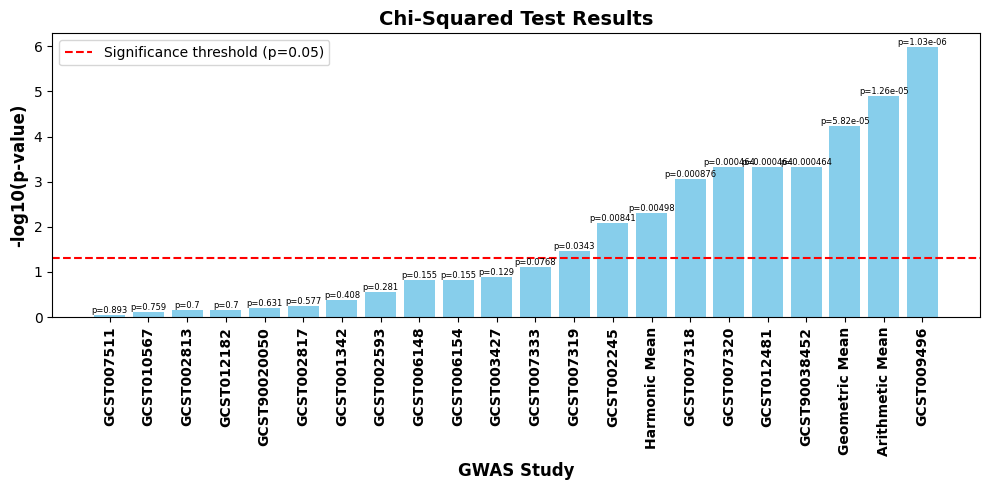

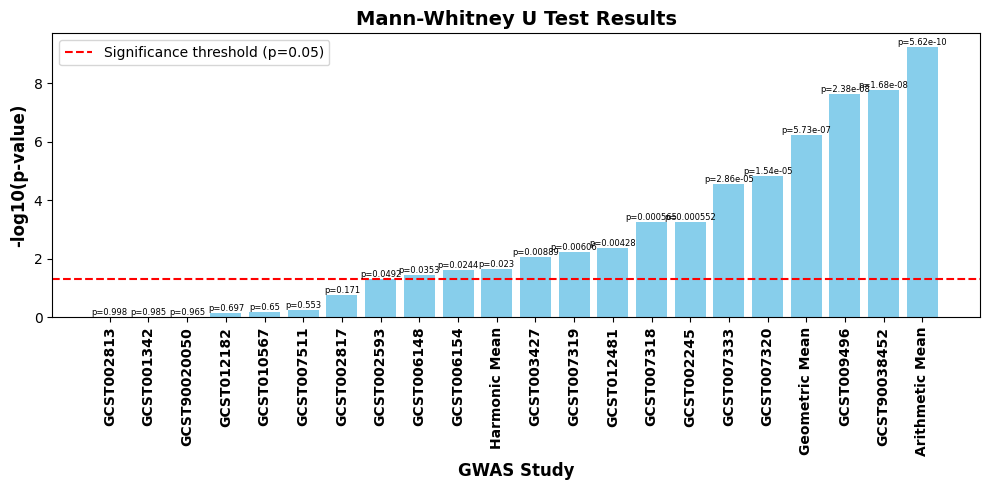

In [52]:
def make_plots(df,options):
    #Sort P-Values so that bars increase in height with significance
    df_sorted = df.sort_values('P-value', ascending=False)

    # Extract sorted lists for plotting
    gwas_studies = df_sorted['Columns'].tolist()
    p_values = df_sorted['P-value'].tolist()

    # Calculate the negative log of the p-values
    neg_log_p_values = [-np.log10(p) if p > 0 else np.nan for p in p_values]  # Using nan for p-value of 0 (log(0) is undefined)

    # Create the bar graph
    plt.figure(figsize=(10, 5))
    colors = ['skyblue' for study in gwas_studies]
    bars = plt.bar(gwas_studies, neg_log_p_values, color=colors)

    # Add a line for the typical significance threshold (e.g., p < 0.05)
    significance_threshold = -np.log10(0.05)
    plt.axhline(y=significance_threshold, color='red', linestyle='--', label='Significance threshold (p=0.05)')

    # Annotate the bars with the actual p-values
    for bar, p_value in zip(bars, p_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'p={p_value:.3g}', 
                ha='center', va='bottom', fontsize=6,rotation='horizontal')

    # Setting the labels and title
    plt.xlabel('GWAS Study', fontsize=12, fontweight='bold')
    plt.ylabel('-log10(p-value)', fontsize=12, fontweight='bold')
    plt.title(f'{options} Results', fontsize=14, fontweight='bold')
    plt.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, fontsize=10, fontweight='bold')

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example Usage
chisq_plot = make_plots(chisq,"Chi-Squared Test")
mannwhitney_plot = make_plots(mannwhitney, "Mann-Whitney U Test")

### 14. Save Output
- Save final DataFrame 'final_df' as a CSV, TSV, or Excel (XLSX) file for viewing or further analysis
- Arguments: DataFrame, Filetype, and Path on your machine

In [50]:
def save_output(df, option, path):
    # Options are 'CSV','TSV', or 'XLSX'
    if option == 'CSV':
        df.to_csv(path,index=True)
        print("CSV File Saved")
    elif option == 'TSV':
        df.to_csv(path,index=True,sep='\t')
        print("TSV File Saved")
    elif option == 'XLSX':
        df.to_excel(path,index=True)
        print("XLSX (Excel) File Saved")
    else: 
        print("Pick filetype option: 'CSV','TSV', or 'XLSX' ")

# final_csv = save_output(final_df,'CSV',path) # Example usage